In [2]:
# General Imports
import numpy as np
import pandas as pd
from collections import Counter
import time

# Visualisation Imports
import matplotlib.pyplot as plt

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel, FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit.algorithms.state_fidelities import ComputeUncompute

# from ipynb.fs.full.EDA import vowelData
# from ipynb.fs.full.EDA import irisData
# from ipynb.fs.full.EDA import breastcancerData

# Loading the dataset

In [3]:
from sklearn.datasets import load_breast_cancer
breast = load_breast_cancer()
n_samples = 1000
n_feats = 10
indexes = np.random.randint(0, 560, n_samples)
x = breast.data[:n_samples,:n_feats]
y = breast.target[:n_samples]
x.shape

(569, 10)

In [3]:
#call one of the function to load the dataset
#df_, x ,y = vowelData ()
#df_, x ,y = irisData ()
df_, x ,y = breastcancerData()


Traceback (most recent call last):
  Cell In[3], line 4
    df_, x ,y = breastcancerData()
NameError: name 'breastcancerData' is not defined

Use %tb to get the full traceback.


In [4]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
num_qubits = x.shape[1]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(455, 10) (455,) (114, 10) (114,)


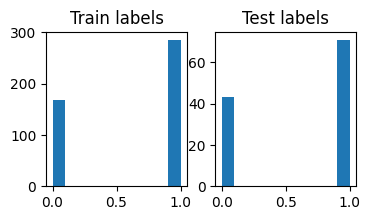

In [5]:
fig, ax = plt.subplots(1,2, figsize=(4,2))

ax[0].hist(y_train)
ax[0].set_title("Train labels")
ax[1].hist(y_test)
ax[1].set_title("Test labels")
plt.show()

# Quantum things

With our training and testing datasets ready, we set up the QuantumKernel class with the ZZFeatureMap, and use the BasicAer statevector_simulator to estimate the training and testing kernel matrices.

In [ ]:
zz_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement='linear', insert_barriers=True)

zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

Let's calculate the transition amplitude between the first and second training data samples, one of the entries in the training kernel matrix.

Let's create a circuit for the first sample and try to simulate

In [ ]:
zz_circuit = zz_kernel.construct_circuit(X_train[0], X_train[1])
# zz_circuit.decompose().decompose().draw(output='mpl')

We then simulate the circuit. We will use the `qasm_simulator` since the circuit contains measurements, but increase the number of shots to reduce the effect of sampling noise.

## QuantumKernel

In [9]:
from qiskit.circuit.random import random_circuit
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
start_time = time.time()

options = Options()
options.optimization_level = 2
options.resilience_level = 0

service = QiskitRuntimeService()
with Session(service=service, backend="ibmq_qasm_simulator") as session:
    #num_qubits = len(Counter(y))
    zz_map = ZZFeatureMap(feature_dimension=n_feats, reps=2, entanglement='linear', insert_barriers=True)
    zz_kernel = QuantumKernel(feature_map=zz_map,quantum_instance=Aer.get_backend("qasm_simulator"))
    zz_circuit = zz_kernel.construct_circuit(X_train[0], X_train[1])
    
    sampler = Sampler(session=session, options=options)
    job = sampler.run(zz_circuit)
    result = job.result()
    
#display(circuit.draw("mpl"))
#print(f" > Quasi probability distribution: {result.quasi_dists[0]}")
print(f" > Metadata: {result.metadata[0]}")
print("Execution time: ", time.time() - start_time)

 > Metadata: {'shots': 4000}
Execution time:  1524.5866510868073
Execution time:  1524.5867023468018


In [8]:
start_time = time.time()
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(X_train, y_train)
zzcb_score = zzcb_svc.score(X_test, y_test)
    
print(f'Callable kernel classification test score: {zzcb_score}')
print("Execution time: ", time.time() - start_time)

Traceback (most recent call last):
  Cell In[8], line 6
    print(f'Callable kernel classification test score: {zzcb_score}')
NameError: name 'zzcb_score' is not defined

Use %tb to get the full traceback.


## FidelityQuantumKernel

In [6]:
from qiskit.circuit.random import random_circuit
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Options
start_time = time.time()

options = Options()
options.optimization_level = 2
options.resilience_level = 0

service = QiskitRuntimeService()
with Session(service=service, backend="ibmq_qasm_simulator") as session:
    
    sampler = Sampler(session=session, options=options)
    zz_map = ZZFeatureMap(feature_dimension=n_feats, reps=2, entanglement='linear', insert_barriers=True)
    fidelity = ComputeUncompute(sampler=sampler)
    zz_kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=zz_map)      
   
print("Execution time: ", time.time() - start_time)

Execution time:  4.730088710784912


In [7]:
start_time = time.time()
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(X_train, y_train)
zzcb_score = zzcb_svc.score(X_test, y_test)
    
print(f'Callable kernel classification test score: {zzcb_score}')
print("Execution time: ", time.time() - start_time)

Traceback (most recent call last):
  Cell In[7], line 3
    zzcb_svc.fit(X_train, y_train)
  File /opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:252 in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File /opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:312 in _dense_fit
    X = self._compute_kernel(X)
  File /opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:513 in _compute_kernel
    kernel = self.kernel(X, self.__Xfit)
  File /opt/conda/lib/python3.10/site-packages/qiskit_machine_learning/kernels/fidelity_quantum_kernel.py:105 in evaluate
    kernel_matrix = self._get_symmetric_kernel_matrix(
  File /opt/conda/lib/python3.10/site-packages/qiskit_machine_learning/kernels/fidelity_quantum_kernel.py:196 in _get_symmetric_kernel_matrix
    kernel_entries = self._get_kernel_entries(left_parameters, right_parameters)
  File /opt/conda/lib/python3.10/site-packages/qiskit_machine_learning/kernels/fidelity_quantum_kernel.py:218 in

Using SVC with the evaluated kernel is the same as using directly QSVC 

In [ ]:
start_time = time.time()
qsvc = QSVC(quantum_kernel=zz_kernel)
qsvc.fit(X_train, y_train)
qsvc_score = qsvc.score(X_test, y_test)

print(f"QSVC classification test score: {qsvc_score}")
print("Execution time: ", time.time() - start_time)